<a href="https://colab.research.google.com/github/COTILab/MCX24Workshop/blob/master/Training/MCX2024_2C_redbird_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!#@title Init 1: Initial setup of environment for running MCXLAB (run the below section once)
# install octave and oct2py
! sudo apt-get update && sudo apt-get install octave jq libpocl2 pocl-opencl-icd    # install octave (a free matlab clone)
! pip install oct2py jdata bjdata matplotlib   # install oct2py, jdata, bjdata and matplotlib Python modules
#!apt-get install nvidia-opencl-icd-384        # optional: install nvidia OpenCL(+2min), needed for mmc/mmclab demos later
# add octave support to colab notebook
%load_ext oct2py.ipython
# download and unzip mcxlab
! rm -rf mcxlab*
! wget https://mcx.space/nightly/release/MCX24/MCXStudio-linux-x86_64-nightlybuild.zip  # download MCX suite
! unzip -o MCXStudio-linux-x86_64-nightlybuild.zip && rm -rf MCXStudio-linux-x86_64-nightlybuild.zip # unzip MCX suite

# add executable to the shell's paths
! sudo cp -a $PWD/MCXStudio/MCXSuite/mcx/bin/mcx /usr/local/bin
! sudo cp -a $PWD/MCXStudio/MCXSuite/mcxcl/bin/mcxcl /usr/local/bin
! sudo cp -a $PWD/MCXStudio/MCXSuite/mmc/bin/mmc /usr/local/bin
# if a GPU runtime can not be allocated, run this section to setup OpenCL and MCXLAB-CL
! [[ ! -f `which nvidia-smi` ]] && sudo mv /usr/local/bin/mcxcl /usr/local/bin/mcx
! mcx -L

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [2,632 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,394 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/mai

In [2]:
%%octave

addpath([pwd filesep 'MCXStudio/MATLAB/redbird-m' filesep 'matlab']); % add path to redbird-m
addpath([pwd filesep 'MCXStudio/MATLAB/mcxlab']);                     % add path to mcxlab
addpath([pwd filesep 'MCXStudio/MCXSuite/mcx' filesep 'utils']);      % add path to mcx helper functions
addpath([pwd filesep 'MCXStudio/MATLAB/mmclab']);                     % add path to mmclab
addpath([pwd filesep 'MCXStudio/MCXSuite/mmc' filesep 'matlab']);     % add path to mmc helper functions
addpath([pwd filesep 'MCXStudio/MATLAB/iso2mesh']);                   % add path to iso2mesh/jsonlab
addpath([pwd filesep 'MCXStudio/MATLAB/brain2mesh']);                 % add path to brain2mesh
addpath([pwd filesep 'MCXStudio/MATLAB/zmat']);                       % add path to zmat for data compression

if(system('which nvidia-smi'))                   % if this runtime does not have NVIDIA GPU support
    addpath([pwd filesep 'MCXStudio/MATLAB/mcxlabcl']);    % add path to mcxlabcl
    USE_MCXCL=1;                                 % set USE_MCXCL flag in the base workspace
end

/opt/bin/nvidia-smi

## Forward validation of Redbird-m

In this section, we compare the forward solutions produced by Redbird-m and mcx to validate that both toolboxes produce similar results.

We show you examples of the forward solutions produced on a homogeneous domain using a single point source or an array of wide-field patterns.

In general, Redbird-m and mmclab (as well as mcxlab) share a similar data structure - i.e. the simulation settings are passed onto redbird functions in the form a MATLAB/Octave `struct` object, similar to the `cfg` struct we discussed in earlier sessions.

### Single point-source forward validation
In the below example we prepare the general setting for running a forward simulation of a homogeneous domain using a single point source for both Redbird-m and MCX.

#### Define general parameters for Redbird-m single point-source forward simulation

generating tetrahedral mesh from closed surfaces ...

creating volumetric mesh from a surface mesh ...

volume mesh generation is complete

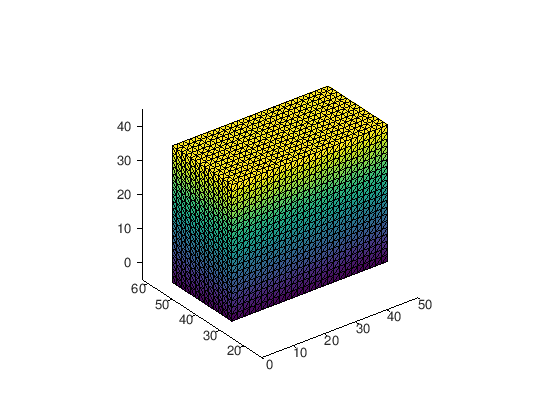

In [3]:
%%octave

clear cfg0
clc

% Generate homogeneous domain
domsz   = [50 50 40]; % Domain size
resmesh = 2;
[nobbx,elembbx] = meshgrid5(0:resmesh:domsz(1),0:resmesh:domsz(2),0:resmesh:domsz(3)); % Meshbox domain (in mm)
fcbbx   = volface(elembbx);
[cfg0.node, cfg0.elem] = s2m(nobbx,fcbbx(:,1:3),1,25,'tetgen1.5',[11 1 1]); % Generate measured/real heterogeneous domain
cfg0.elem = cfg0.elem(:,1:4);
clear nobbx elembbx fcbbx
cfg0.seg = ones(size(cfg0.elem,1),1);

% Visualize domain
figure, plotmesh(cfg0.node, cfg0.elem,'y>25')

% General settings for RB simulations
cfg0.prop  = [0       0 1 1   ; ...
              0.006 0.8 0 1.37];

% Define RB point source simulation parameters
cfg0.srcpos = [24.5 24.5 0];
cfg0.srcdir = [0 0  1];
cfg0.detpos = [34.5 24.5 domsz(3)];
cfg0.detdir = [0 0 -1];

cfg = cfg0;
[cfg0,sd0] = rbmeshprep(cfg0);

% Run RB forward simulation
[detphi0,phi0] = rbrunforward(cfg0,'sd',sd0);


#### Define general parameters for MCX single point-source forward simulation

In [7]:
%%octave

clear xcfg
clc

xcfg.nphoton    = 1e8;
xcfg.vol        = uint8(ones(domsz));
xcfg.gpuid      = 1;
xcfg.autopilot  = 1;
xcfg.prop       = cfg0.prop;
xcfg.tstart     = 0;
xcfg.tend       = 5e-9;
xcfg.tstep      = 5e-9;
xcfg.seed       = 99999;
xcfg.issrcfrom0 = 0;
xcfg.isreflect  = 1;
xcfg.unitinmm   = 1;

% Define MCX point source forward simulation
xcfg.srcpos     = [25 25 0];
xcfg.srcdir     = [0 0 1];

% Run MCX forward simulation
flux = mcxlab(xcfg);
fcw  = flux.data*xcfg.tstep;


Launching MCXLAB - Monte Carlo eXtreme for MATLAB & GNU Octave ...

Running simulations for configuration #1 ...

mcx.nphoton=1e+08;

mcx.dim=[50 50 40];

mcx.mediabyte=1;

mcx.gpuid=1;

mcx.autopilot=1;

mcx.medianum=2;

mcx.tstart=0;

mcx.tend=5e-09;

mcx.tstep=5e-09;

mcx.seed=99999;

mcx.issrcfrom0=0;

mcx.isreflect=1;

mcx.unitinmm=1;

mcx.srcpos=[25 25 0 1];

mcx.srcdir=[0 0 1 0];

###############################################################################

#                      Monte Carlo eXtreme (MCX) -- CUDA                      #

#          Copyright (c) 2009-2024 Qianqian Fang <q.fang at neu.edu>          #

#                https://mcx.space/  &  https://neurojson.io/                 #

#                                                                             #

# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #

#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #

###############################################################################

#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #

###############################################################################

#  Open-source codes and reusable scientific data are essential for research, #

# MCX proudly developed human-readable JSON-based data formats for easy reuse.#

#                                                                             #

#Please visit our free scientific data sharing portal at https://neurojson.io/#

# and consider sharing your public datasets in standardized JSON/JData format #

###############################################################################

$Rev::f959c7$v2024.6 $Date::2024-06-22 15:23:34 -04$ by $Author::Qianqian Fang$

###############################################################################

- code name: [Jumbo Jolt] compiled by nvcc [9.0] for CUDA-arch [350] on [Jun 26 2024]

- compiled with: RNG [xorshift128+] with Seed Length [4]

GPU=1 (Tesla T4) threadph=1220 extra=57600 np=100000000 nthread=81920 maxgate=1 repetition=1

initializing streams ...	init complete : 0 ms

requesting 1280 bytes of shared memory

launching MCX simulation for time window [0.00e+00ns 5.00e+00ns] ...

simulation run# 1 ...

kernel complete:  	3336 ms

retrieving fields ... 	transfer complete:	3338 ms

normalizing raw data ...	source 1, normalization factor alpha=2.000000

data normalization complete : 3342 ms

simulated 100000000 photons (100000000) with 81920 threads (repeat x1)

MCX simulation speed: 30385.90 photon/ms

total simulated energy: 100000000.00	absorbed: 30.53019%

(loss due to initial specular reflection is excluded in the total)

#### Compare MCX & Redbird-m solutions for single point-source solutions

ans = -16.025

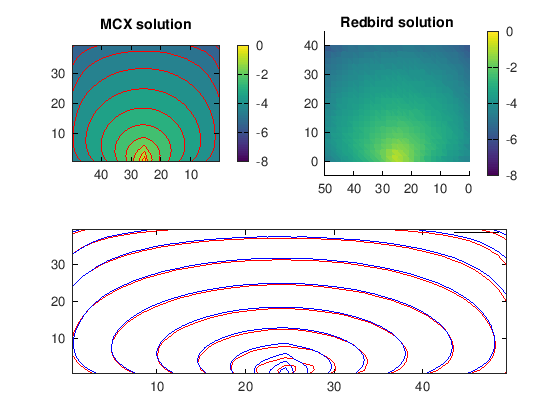

In [8]:
%%octave

clc

if isfield(cfg0,'srcpos0')
  zslice = cfg0.srcpos0(1)+1;
else
  zslice = cfg0.srcpos(1)+1;
end
clim = [-8 0];

clc
figure,
subplot(2,2,1)
contourf(xi,yi,rot90(log10(abs(squeeze(fcw(:,xcfg.srcpos(2),:)))),-1),clines,'r-','LineWidth',2)
set(gca,'xlim',[0 domsz(1)],'ylim',[0 domsz(3)],'YDir','Normal','XDir','Reverse')
axis equal
axis tight
colorbar
caxis([clim(1) clim(2)])
title('MCX solution');

subplot(2,2,2)
plotmesh([cfg0.node full(log10(phi0(:,1)))],cfg0.elem,char(strcat('x>',num2str(zslice))))
view([-1 0 0]);
shading interp;
colorbar;
caxis([clim(1) clim(2)])
title('Redbird solution');


subplot(2,2,3:4)
clines = 0:-0.5:-8;
[xi,yi] = meshgrid(0.5:domsz(1)-0.5,0.5:domsz(3)-0.5);
[cutpos,cutvalue,facedata] = qmeshcut(cfg0.elem,cfg0.node,phi0(:,1),char(strcat('x=',num2str(zslice))));
vphi = griddata(cutpos(:,2),cutpos(:,3),cutvalue,xi+0.5,yi+0.5);

[c,h] = contour(xi,yi,log10(vphi),clines,'r-','LineWidth',2);
cwf   = squeeze(fcw(xcfg.srcpos(1),:,:,1))';
hold on,contour(xi,yi,log10(cwf),clines,'b-','LineWidth',2);
legend('RedBird','MCX')


### Wide-field source forward validation
In the below example we prepare the general setting for running a forward simulation of a homogeneous domain using a set of sliding-bar source patterns for both Redbird-m and MCX.

#### Define general parameters for Redbird-m wide-field source forward simulation

In this section we first generate a 50x50x40 mm homogeneous mesh; then we create a set of 16 sliding-bar source patterns (8 in x-direction and 8 in y-direction) and run the forward simulation in Redbirm-m.

generating tetrahedral mesh from closed surfaces ...

creating volumetric mesh from a surface mesh ...

volume mesh generation is complete

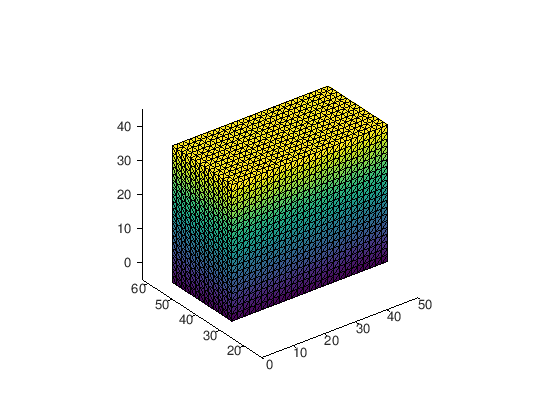

In [9]:
%%octave

clear cfg0
clc

% Generate homogeneous domain
domsz   = [50 50 40]; % Domain size
resmesh = 2;
[nobbx,elembbx] = meshgrid5(0:resmesh:domsz(1),0:resmesh:domsz(2),0:resmesh:domsz(3)); % Meshbox domain (in mm)
fcbbx   = volface(elembbx);
[cfg0.node, cfg0.elem] = s2m(nobbx,fcbbx(:,1:3),1,25,'tetgen1.5',[11 1 1]); % Generate measured/real heterogeneous domain
cfg0.elem = cfg0.elem(:,1:4);
clear nobbx elembbx fcbbx
cfg0.seg = ones(size(cfg0.elem,1),1);

% Visualize domain
figure, plotmesh(cfg0.node, cfg0.elem,'y>25')

% General settings for RB simulations
cfg0.prop  = [0       0 1 1   ; ...
              0.006 0.8 0 1.37];

% Define RB wide-field source simulation parameters
nBarpats   = 4; % Number of bar patterns in x/y directions
srcpattern = diag(ones(1,nBarpats));
srcpattern = permute(repmat(srcpattern,[1,1,size(srcpattern, 1)]),[2 3 1]);
srcpattern = cat(3,srcpattern,permute(srcpattern,[2 1 3]));
detpattern = srcpattern;
cfg0.srctype    = 'pattern';
cfg0.srcpattern = srcpattern;
cfg0.srcpos     = [9.5 9.5 0];
cfg0.srcparam1  = [ 30   0 0 0];
cfg0.srcparam2  = [  0  30 0 0];
cfg0.srcdir     = [  0   0 1];
cfg0.srcweight  = ones(1,nBarpats);
cfg0.dettype    = 'pattern';
cfg0.detpattern = detpattern;
cfg0.detpos     = [9.5 9.5 domsz(3)];
cfg0.detparam1  = [ 30   0  0 0];
cfg0.detparam2  = [  0  30  0 0];
cfg0.detdir     = [  0   0 -1];
cfg0.detweight  = ones(1,nBarpats);

cfg = cfg0;
[cfg0,sd0] = rbmeshprep(cfg0);

% Run RB forward simulation
[detphi0,phi0] = rbrunforward(cfg0,'sd',sd0);

#### Define general parameters for MCX wide-field source forward simulation

In this section we first generate a 50x50x40 mm homogeneous voxelized domain; then we create a set of 16 sliding-bar source patterns (8 in x-direction and 8 in y-direction) and rn=un the forward simulation in MCX.

In [11]:
%%octave

clear xcfg
clc

xcfg.nphoton    = 1e8;
xcfg.vol        = uint8(ones(domsz));
xcfg.gpuid      = 1;
xcfg.autopilot  = 1;
xcfg.prop       = cfg0.prop;
xcfg.tstart     = 0;
xcfg.tend       = 5e-9;
xcfg.tstep      = 5e-9;
xcfg.seed       = 99999;
xcfg.issrcfrom0 = 0;
xcfg.isreflect  = 1;
xcfg.unitinmm   = 1;

% Define MCX wide-field source forward simulation
xcfg.srctype    = 'pattern';
xcfg.srcpattern = permute(srcpattern,[3 1 2]);
xcfg.srcnum     = size(srcpattern,3);
xcfg.srcdir     = [0 0 1];
xcfg.srcpos     = [10 10 0];
xcfg.srcparam1  = [30  0 0 size(srcpattern,1)];
xcfg.srcparam2  = [ 0 30 0 size(srcpattern,2)];
xcfg.outputtype = 'fluence';

% Run MCX forward simulation
flux = mcxlab(xcfg);
fcw  = flux.data;

Launching MCXLAB - Monte Carlo eXtreme for MATLAB & GNU Octave ...

Running simulations for configuration #1 ...

mcx.nphoton=1e+08;

mcx.dim=[50 50 40];

mcx.mediabyte=1;

mcx.gpuid=1;

mcx.autopilot=1;

mcx.medianum=2;

mcx.tstart=0;

mcx.tend=5e-09;

mcx.tstep=5e-09;

mcx.seed=99999;

mcx.issrcfrom0=0;

mcx.isreflect=1;

mcx.unitinmm=1;

mcx.srctype='pattern';

mcx.srcpattern=[8 4 4];

mcx.srcnum=8;

mcx.srcdir=[0 0 1 0];

mcx.srcpos=[10 10 0 1];

mcx.srcparam1=[30 0 0 4];

mcx.srcparam2=[0 30 0 4];

mcx.outputtype='fluence';

###############################################################################

#                      Monte Carlo eXtreme (MCX) -- CUDA                      #

#          Copyright (c) 2009-2024 Qianqian Fang <q.fang at neu.edu>          #

#                https://mcx.space/  &  https://neurojson.io/                 #

#                                                                             #

# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #

#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #

###############################################################################

#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #

###############################################################################

#  Open-source codes and reusable scientific data are essential for research, #

# MCX proudly developed human-readable JSON-based data formats for easy reuse.#

#                                                                             #

#Please visit our free scientific data sharing portal at https://neurojson.io/#

# and consider sharing your public datasets in standardized JSON/JData format #

###############################################################################

$Rev::f959c7$v2024.6 $Date::2024-06-22 15:23:34 -04$ by $Author::Qianqian Fang$

###############################################################################

- code name: [Jumbo Jolt] compiled by nvcc [9.0] for CUDA-arch [350] on [Jun 26 2024]

- compiled with: RNG [xorshift128+] with Seed Length [4]

GPU=1 (Tesla T4) threadph=1220 extra=57600 np=100000000 nthread=81920 maxgate=1 repetition=1

initializing streams ...	init complete : 0 ms

requesting 3072 bytes of shared memory

launching MCX simulation for time window [0.00e+00ns 5.00e+00ns] ...

simulation run# 1 ...

kernel complete:  	6630 ms

retrieving fields ... 	transfer complete:	6632 ms

normalizing raw data ...	source 1, normalization factor alpha=0.000000

source 2, normalization factor alpha=0.000000

source 3, normalization factor alpha=0.000000

source 4, normalization factor alpha=0.000000

source 5, normalization factor alpha=0.000000

source 6, normalization factor alpha=0.000000

source 7, normalization factor alpha=0.000000

source 8, normalization factor alpha=0.000000

data normalization complete : 6663 ms

simulated 100000000 photons (100000000) with 81920 threads (repeat x1)

MCX simulation speed: 15135.46 photon/ms

source #1 total simulated energy: 25000000.00	absorbed: 27.56910%

(loss due to initial specular reflection is excluded in the total)

source #2 total simulated energy: 25000000.00	absorbed: 29.29320%

(loss due to initial specular reflection is excluded in the total)

source #3 total simulated energy: 25000000.00	absorbed: 29.45366%

(loss due to initial specular reflection is excluded in the total)

source #4 total simulated energy: 25000000.00	absorbed: 28.24256%

(loss due to initial specular reflection is excluded in the total)

source #5 total simulated energy: 25000000.00	absorbed: 27.55714%

(loss due to initial specular reflection is excluded in the total)

source #6 total simulated energy: 25000000.00	absorbed: 29.30216%

(loss due to initial specular reflection is excluded in the total)

source #7 total simulated energy: 25000000.00	absorbed: 29.45123%

(loss due to initial specular reflection is excluded in the total)

source #8 total simulated energy: 25000000.00	absorbed: 28.24799%

(loss due to initial specular reflection is excluded in the total)

#### Compare MCX & Redbird-m solutions for sliding-bar source pattern solutions



ans = -33.246

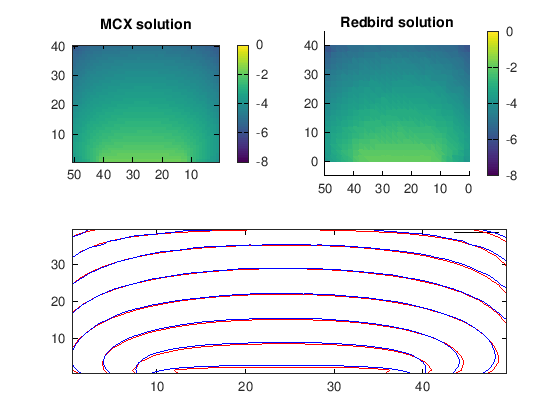

In [12]:
%%octave

clc

if isfield(cfg0,'srcpos0')
  zslice = cfg0.srcpos0(1)+1;
else
  zslice = cfg0.srcpos(1)+1;
end
clim = [-8 0];

clc
figure,
subplot(2,2,1)
imagesc(rot90(log10(abs(squeeze(fcw(xcfg.srcpos(1),:,:,1)))),-1))
set(gca,'xlim',[0 domsz(1)],'ylim',[0 domsz(3)],'YDir','Normal','XDir','Reverse')
axis equal
axis tight
colorbar
caxis([clim(1) clim(2)])
title('MCX solution');

subplot(2,2,2)
plotmesh([cfg0.node full(log10(phi0(:,1)))],cfg0.elem,char(strcat('x>',num2str(zslice))))
view([-1 0 0]);
shading interp;
colorbar;
caxis([clim(1) clim(2)])
title('Redbird solution');

subplot(2,2,3:4)
clines = 0:-0.5:-8;
[xi,yi] = meshgrid(0.5:domsz(1)-0.5,0.5:domsz(3)-0.5);
[cutpos,cutvalue,facedata] = qmeshcut(cfg0.elem,cfg0.node,phi0(:,1),char(strcat('x=',num2str(zslice))));
vphi = griddata(cutpos(:,2),cutpos(:,3),cutvalue,xi+0.5,yi+0.5);

[c,h] = contour(xi,yi,log10(vphi),clines,'r-','LineWidth',2);
cwf   = squeeze(fcw(xcfg.srcpos(1),:,:,1))';
hold on,contour(xi,yi,log10(cwf),clines,'b-','LineWidth',2);
legend('RedBird','MCX')


## Getting to know Redbird-m forward functionalities

In the below sections we introduce some of the functionalities of Redbird-m. We show how to produce forward simulations of continuous (CW) and frequency-domain (FD) illuminations using either arrays of point-sources/detector or sets of wide-field source/detector patterns.

### Forward simulations of CW/FD point-source arrays using Redbird-m

In this example we generate a 50x50x40 homogeneous domain to run forward simulations of an array of 3x3 point-sources located at the bottom syrface of the mesh as well as an array of 3x3 point-detectors located at the top surface of the domain. We demonstrate the capability of Redbird-m to produce forward solution of CW or FD point illumination and detection.

generating tetrahedral mesh from closed surfaces ...

creating volumetric mesh from a surface mesh ...

volume mesh generation is complete

mfreq = 0

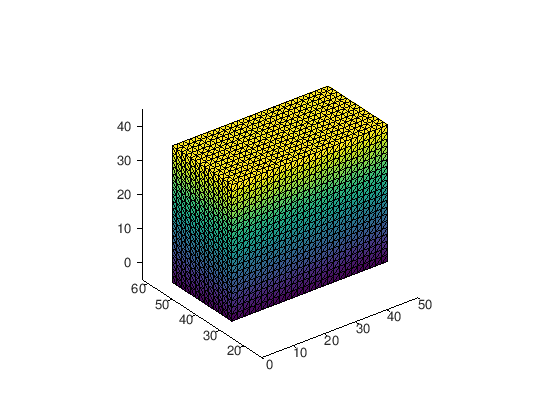

In [13]:
%%octave

clear cfg0
clc

% Generate homogeneous domain
domsz   = [50 50 40]; % Domain size
resmesh = 2;
[nobbx,elembbx] = meshgrid5(0:resmesh:domsz(1),0:resmesh:domsz(2),0:resmesh:domsz(3)); % Meshbox domain (in mm)
fcbbx   = volface(elembbx);
[cfg0.node, cfg0.elem] = s2m(nobbx,fcbbx(:,1:3),1,25,'tetgen1.5',[11 1 1]); % Generate measured/real heterogeneous domain
cfg0.elem = cfg0.elem(:,1:4);
clear nobbx elembbx fcbbx
cfg0.seg = ones(size(cfg0.elem,1),1);

% Visualize domain
figure, plotmesh(cfg0.node, cfg0.elem,'y>25')

% General settings for RB simulations
cfg0.prop  = [0       0 1 1   ; ...
              0.006 0.8 0 1.37];
mfreq      = 0 # @param [0, 135] {type:"raw"}
cfg0.omega = mfreq*1e6*2*pi;

% Define parameters for RB point-source array simulation
nsrc        = [3 3]; % Number of point src/det in xy axis
[xi,yi]     = meshgrid(linspace(10,40,nsrc(1)),linspace(10,40,nsrc(2)));
cfg0.srcpos = [xi(:),yi(:),zeros(numel(yi),1)];
cfg0.detpos = [xi(:),yi(:),domsz(3)*ones(numel(yi),1)];
cfg0.srcdir = [0 0  1];
cfg0.detdir = [0 0 -1];

cfg = cfg0;
[cfg0,sd0] = rbmeshprep(cfg0);

% Run RB forward simulation
[detphi0,phi0] = rbrunforward(cfg0,'sd',sd0);


### Visualize Redbird-m point-source array forward simulations

idxsrc = 8

detid = 9

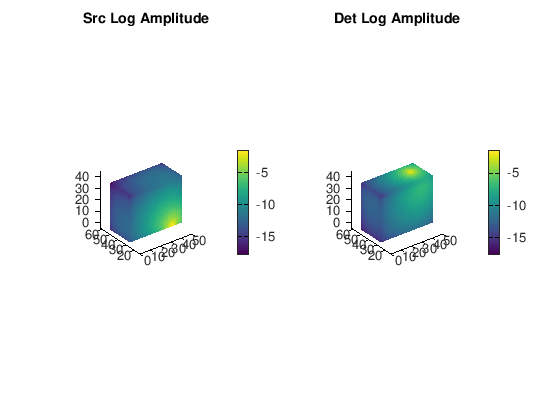

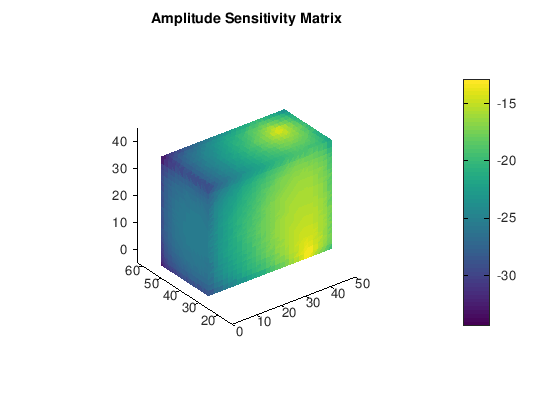

In [15]:
%%octave

clc

% Select src/det optodes to visualize
idxsrc = 8 # @param [1,2,3,4,5,6,7,8,9] {type:"raw"}
detid  = 9 # @param [1,2,3,4,5,6,7,8,9] {type:"raw"}
idxdet = detid + 9;

if ~isreal(phi0) % If FD simulation
  nplot = 2;
else
  nplot = 1;
end

figure,
subplot(nplot,2,1),plotmesh([cfg0.node log(abs(phi0(:,idxsrc)))],cfg0.elem,char(strcat('y>25'))),shading interp,colorbar,title('Src Log Amplitude') % Visualize fluence amplitude from det#10
subplot(nplot,2,2),plotmesh([cfg0.node log(abs(phi0(:,idxdet)))],cfg0.elem,char(strcat('y>25'))),shading interp,colorbar,title('Det Log Amplitude') % Visualize fluence amplitude from det#10
if ~isreal(phi0)
  subplot(nplot,2,3),plotmesh([cfg0.node   angle(phi0(:,idxsrc))],cfg0.elem,char(strcat('y>25'))),shading interp,colorbar,title('Src Phase') % Visualize fluence phase from det#10
  subplot(nplot,2,4),plotmesh([cfg0.node   angle(phi0(:,idxdet))],cfg0.elem,char(strcat('y>25'))),shading interp,colorbar,title('Det Phase') % Visualize fluence phase from det#10
end

% Visualize sensitivity matrix
figure,plotmesh([cfg0.node   log(abs(prod(phi0(:,[idxsrc idxdet]),2)))],cfg0.elem,'y>25') ,shading interp,colorbar,title('Amplitude Sensitivity Matrix') % Visualize sensitivity matrix src#1 & det#10
if ~isreal(phi0)
  figure,plotmesh([cfg0.node angle(prod(phi0(:,[idxsrc idxdet]),2))],cfg0.elem,'y>25') ,shading interp,colorbar,title('Phase Sensitivity Matrix') % Visualize sensitivity matrix src#1 & det#10
end


### Forward simulations of CW/FD wide-field source/detector patterns using Redbird-m

In this example we generate a 50x50x40 homogeneous domain to run forward simulations of a total of 8 wide-field source patterns (4 in x-direction, 4 in y-direction) located at the bottom surface of the mesh as well as similar set of 8 wide-field detector patterns (4 in x-direction, 4 in y-direction) located at the top surface of the domain. We demonstrate the capability of Redbird-m to produce forward solution of CW or FD wide-field illuminations/detections.

generating tetrahedral mesh from closed surfaces ...

creating volumetric mesh from a surface mesh ...

volume mesh generation is complete

mfreq = 135

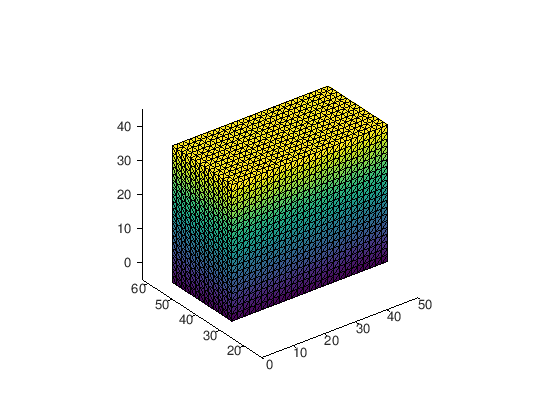

In [16]:
%%octave

clear cfg0
clc

% Generate homogeneous domain
domsz   = [50 50 40]; % Domain size
resmesh = 2;
[nobbx,elembbx] = meshgrid5(0:resmesh:domsz(1),0:resmesh:domsz(2),0:resmesh:domsz(3)); % Meshbox domain (in mm)
fcbbx   = volface(elembbx);
[cfg0.node, cfg0.elem] = s2m(nobbx,fcbbx(:,1:3),1,25,'tetgen1.5',[11 1 1]); % Generate measured/real heterogeneous domain
cfg0.elem = cfg0.elem(:,1:4);
clear nobbx elembbx fcbbx
cfg0.seg = ones(size(cfg0.elem,1),1);

% Visualize domain
figure, plotmesh(cfg0.node, cfg0.elem,'y>25')

% General settings for RB simulations
cfg0.prop  = [0       0 1 1   ; ...
              0.006 0.8 0 1.37];
mfreq      = 135 # @param [0, 135] {type:"raw"}
cfg0.omega = mfreq*1e6*2*pi;

% Define RB wide-field source simulation parameters
nBarpats   = 4; % Number of bar patterns in x/y directions
srcpattern = diag(ones(1,nBarpats));
srcpattern = permute(repmat(srcpattern,[1,1,size(srcpattern, 1)]),[2 3 1]);
srcpattern = cat(3,srcpattern,permute(srcpattern,[2 1 3]));
detpattern = srcpattern;
cfg0.srctype    = 'pattern';
cfg0.srcpattern = srcpattern;
cfg0.srcpos     = [10 10 0];
cfg0.srcparam1  = [30  0 0 0];
cfg0.srcparam2  = [ 0 30 0 0];
cfg0.srcdir     = [ 0  0 1];
cfg0.srcweight  = ones(1,nBarpats);
cfg0.dettype    = 'pattern';
cfg0.detpattern = detpattern;
cfg0.detpos     = [10 10 domsz(3)];
cfg0.detparam1  = [30  0  0 0];
cfg0.detparam2  = [ 0 30  0 0];
cfg0.detdir     = [ 0  0 -1];
cfg0.detweight  = ones(1,nBarpats);

cfg = cfg0;
[cfg0,sd0] = rbmeshprep(cfg0);

% Run RB forward simulation
[detphi0,phi0] = rbrunforward(cfg0,'sd',sd0);

### Visualize Redbird-m wide-field source/detector pattern forward simulations

idxsrc = 2

detid = 3

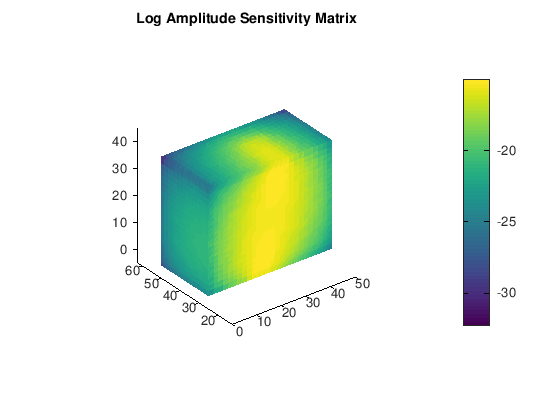

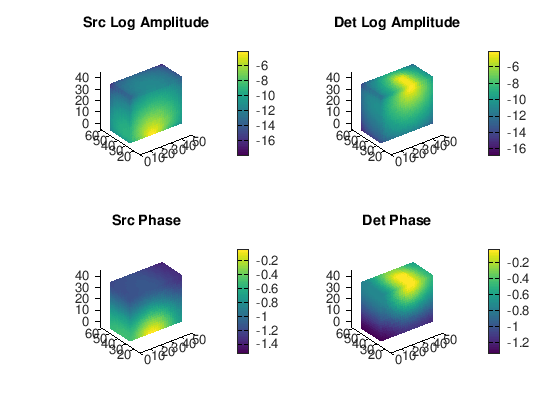

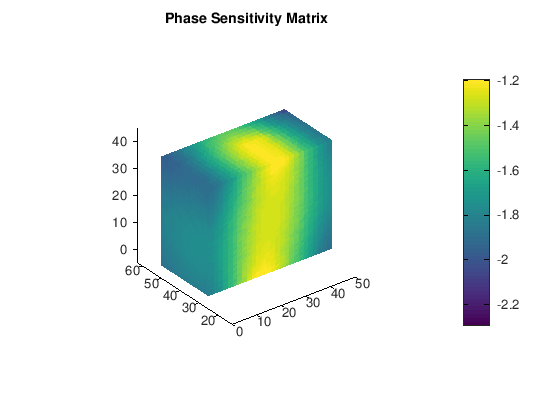

In [17]:
%%octave

clc

% Select src/det optodes to visualize
idxsrc = 2 # @param [1,2,3,4,5,6,7,8] {type:"raw"}
detid  = 3 # @param [1,2,3,4,5,6,7,8] {type:"raw"}
idxdet = detid + 8;

if ~isreal(phi0) % If FD simulation
  nplot = 2;
else
  nplot = 1;
end

figure,
subplot(nplot,2,1),plotmesh([cfg0.node log(abs(phi0(:,idxsrc)))],cfg0.elem,char(strcat('y>25'))),shading interp,colorbar,title('Src Log Amplitude') % Visualize fluence amplitude from det#10
subplot(nplot,2,2),plotmesh([cfg0.node log(abs(phi0(:,idxdet)))],cfg0.elem,char(strcat('y>25'))),shading interp,colorbar,title('Det Log Amplitude') % Visualize fluence amplitude from det#10
if ~isreal(phi0)
  subplot(nplot,2,3),plotmesh([cfg0.node   angle(phi0(:,idxsrc))],cfg0.elem,char(strcat('y>25'))),shading interp,colorbar,title('Src Phase') % Visualize fluence phase from det#10
  subplot(nplot,2,4),plotmesh([cfg0.node   angle(phi0(:,idxdet))],cfg0.elem,char(strcat('y>25'))),shading interp,colorbar,title('Det Phase') % Visualize fluence phase from det#10
end


% Visualize sensitivity matrix
figure,plotmesh([cfg0.node   log(abs(prod(phi0(:,[idxsrc idxdet]),2)))],cfg0.elem,'y>25') ,shading interp,colorbar,title('Log Amplitude Sensitivity Matrix') % Visualize sensitivity matrix src#1 & det#10
if ~isreal(phi0)
  figure,plotmesh([cfg0.node angle(prod(phi0(:,[idxsrc idxdet]),2))],cfg0.elem,'y>25') ,shading interp,colorbar,title('Phase Sensitivity Matrix') % Visualize sensitivity matrix src#1 & det#10
end

## Single-spectra Redbird-m reconstruction using point-source arrays of CW/FD illumination

In this section, we prepare a heterogenous mesh domain of 100x0100x40 mm with two inclusions with 2x absorption contrast located off-center in the z-axis (z = 15 mm).

First, we define the general setting to create the heterogenous domain along with a 4x4 point-source/detector array in a transmission geometry. We run a forward simulation on the heterogeneous domain (cfg0) to create simulated data (detphi0). Then, we create a homogeneous forward mesh (cfg) over which the inverse problem solution will be projected. We also create a sparse reconstruction mesh (recon) to speed up the Jacobian inversion and project those solutions over the forward mesh.

### General parameters for producing synthetic data

In this section we define the general parameters for running Redbird-m forward simulation to create synthetic data of a dual-inclusion heterogeneous domain using a 4x4 point-source array at the bottom of the domain and a similar one at the top of the domain for detection. We then create the forward and reconstruction meshes.

If generating synthetic data using FD point-source, we then perform a bulk optical properties fitting.

Last, using the simulated data (detphi0) and the forward and recon meshes, we perform an iterative reconstruction.

Surface Mesh Extraction Utility (Based on CGAL 3.8)

(modified for iso2mesh by Qianqian Fang)

http://iso2mesh.sf.net

RNG seed 1648335518

set initial mesh size to 50

Refining... maximum node number is set to 40000

done.

Final number of points: 289

WARNING- Some triangles have been reversed to achieve orientation.

Surface Mesh Extraction Utility (Based on CGAL 3.8)

(modified for iso2mesh by Qianqian Fang)

http://iso2mesh.sf.net

RNG seed 1648335518

set initial mesh size to 50

Refining... maximum node number is set to 40000

done.

Final number of points: 289

WARNING- Some triangles have been reversed to achieve orientation.

generating tetrahedral mesh from closed surfaces ...

creating volumetric mesh from a surface mesh ...

volume mesh generation is complete

mfreq = 0

generating tetrahedral mesh from closed surfaces ...

creating volumetric mesh from a surface mesh ...

volume mesh generation is complete

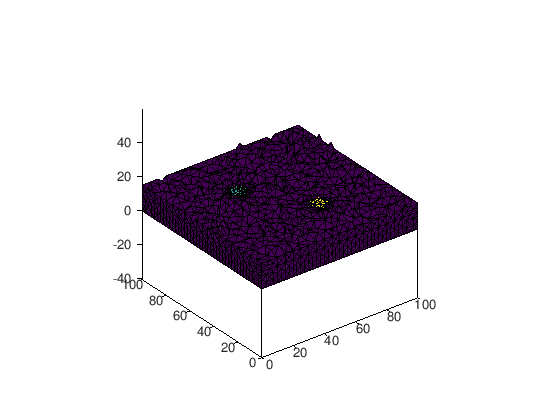

In [18]:
%%octave

clear cfg0 cfg recon
clc

domsz = [100 100 40];     % Domain size
s0    = [35, 65, 15 5;... % Central position xyz and radius of the inclusion (in mm)
         60, 30, 15 5];

% Bounding box w/ 2 inclusions
resmesh = 5;
[nobbx,elembbx] = meshgrid5(0:resmesh:domsz(1),0:resmesh:domsz(2),0:resmesh:domsz(3)); % Meshbox domain (in mm)
fcbbx   = volface(elembbx);
[nobbx,fcbbx] = removeisolatednode(nobbx,fcbbx);
[nosp1,fcsp1] = meshasphere(s0(1,1:3),s0(1,4),1); % Sphare mesh location (s0, radious, maxvol)
[nosp2,fcsp2] = meshasphere(s0(2,1:3),s0(2,4),1); % Sphare mesh location (s1, radious, maxvol)
[no,fc]       = mergemesh(nobbx,fcbbx,nosp1,fcsp1,nosp2,fcsp2); % Merge meshbox and sphere meshes (FOR DUAL INCLUSION DOMAIN)
[cfg0.node, cfg0.elem] = s2m(no,fc(:,1:3),1,25,'tetgen1.5',[11 1 1;s0(1,1:3);s0(2,1:3)]); % Generate measured/real heterogeneous domain
clear nobbx elembbx fcbbx nosp1 fcsp1 nosp2 fcsp2 no fc

% Visualize domain
figure, plotmesh(cfg0.node, cfg0.elem,char(strcat('z<',num2str(s0(1,3)))))

% General settings for RB simulations
cfg0.prop = [     0  0 1 1   ; ...
             0.006 0.8 0 1.37; ...
             0.012 0.8 0 1.37; ...
             0.012 0.8 0 1.37];
mfreq      = 0 # @param [0, 135] {type:"raw"}
cfg0.omega = mfreq*1e6*2*pi;

% Define parameters for RB point-source array simulation
nsrc        = [4 4]; % Number of point src/det in xy axis
[xi,yi]     = meshgrid(linspace(20,80,nsrc(1)),linspace(20,80,nsrc(2)));
cfg0.srcpos = [xi(:),yi(:),zeros(numel(yi),1)];
cfg0.detpos = [xi(:),yi(:),domsz(3)*ones(numel(yi),1)];
cfg0.srcdir = [0 0  1];
cfg0.detdir = [0 0 -1];

cfg = cfg0;
[cfg0,sd0] = rbmeshprep(cfg0);

% Run RB forward simulation
[detphi0,phi0] = rbrunforward(cfg0,'sd',sd0);

% Set fwd mesh to be homogeneous
cfg = rbsetmesh(cfg,cfg.node,cfg.elem,cfg.prop,ones(size(cfg.node,1),1));

% Prepare recon mesh
resmesh    = 5;
[no,elem]  = meshgrid5(0:resmesh:domsz(1),0:resmesh:domsz(2),0:resmesh:domsz(3)); % Meshbox domain (in mm)
fc         = volface(elem);
[no,fc]    = removeisolatednode(no,fc);
[recon.node, recon.elem] = s2m(no,fc(:,1:3),1,50,'tetgen1.5');
recon.elem = recon.elem(:,1:4);
[recon.mapid,recon.mapweight] = tsearchn(recon.node,recon.elem(:,1:4),cfg.node);
clear no elem fc

### Run bulk optical properties fitting

If utilizing FD sources, we can then perform a bulk optical properties fitting to decouple absorption and reduce scatterring coefficients. Otherwise, set them to be the true background optical properties used to generate synthetic data.

The bulk optical properties are then set as initial guess for launching the iterative reconstruction procedure.

In [19]:
%%octave

if cfg0.omega > 0 % If simulating FD data, run bulk fitting

  % Set initial guess
  recon.prop = [0     0   1 1    ; ...
                0.008 0.9 0 1.37];

  sd = rbsdmap(cfg);
  [newrecon,resid] = rbrun(cfg,recon,detphi0,sd,'mode','bulk','lambda',1e-5,'maxiter',5);

else % If running CW data, assing bulk optical properties

  % Bulk optical properties to be used
  newrecon.prop = [0       0 1 1    ; ...
                   0.006 0.8 0 1.37];

end

% Set nodal-based optical properties to the bulk fitted values
recon.prop = newrecon.prop(ones(size(recon.node,1),1)+1,:);
cfg.prop   = newrecon.prop(ones(size(cfg.node,1),1)+1,:);
cfg        = rmfield(cfg,'seg');
newrecon.prop

ans =

        0        0   1.0000   1.0000

   0.0060   0.8000        0   1.3700

### Run iterative reconstruction

In [20]:
%%octave

sd = rbsdmap(cfg);
[reconMS,residMS,cfgMS] = rbrun(cfg,recon,detphi0,sd,'mode','image','lambda',1e-6,'maxiter',5);

iter [   1]: residual=1.149662e-05, relres=1.000000e+00 lambda=1.000000e-06 (time=18.594989 s)

iter [   2]: residual=4.916640e-07, relres=4.276597e-02 lambda=1.000000e-06 (time=17.660016 s)

iter [   3]: residual=6.519463e-08, relres=5.670767e-03 lambda=1.000000e-06 (time=18.514666 s)

iter [   4]: residual=4.156574e-08, relres=3.615475e-03 lambda=1.000000e-06 (time=17.385928 s)

iter [   5]: residual=3.323065e-08, relres=2.890472e-03 lambda=1.000000e-06 (time=17.996706 s)

### Visualize reconstructed tomographic images

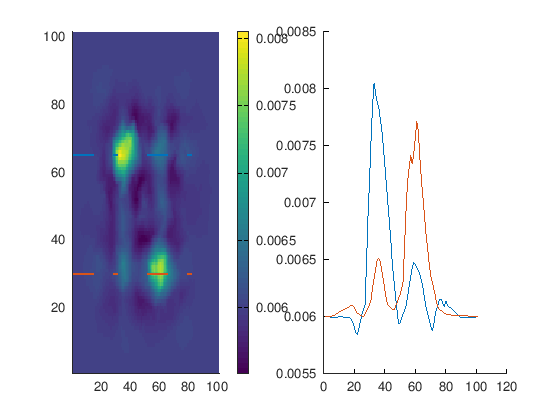

In [36]:
%%octave

% Generate a cross section slice of the domain
[xi,yi]             = meshgrid(min(cfg.node(:,1),[],1):1:max(cfg.node(:,1),[],1),min(cfg.node(:,2),[],1):1:max(cfg.node(:,2),[],1));
[cutpos,cutvalue,~] = qmeshcut(reconMS.elem,reconMS.node,(reconMS.prop(:,1)),char(strcat('z =',num2str(s0(1,3)))));
clear vphi
vphi(:,:,1)         = griddata(cutpos(:,1),cutpos(:,2),cutvalue,xi,yi);

% Visualize results
figure,
subplot(1,2,1),
hold on,imagesc(vphi),colorbar,axis tight
for mm = 1:size(s0,1)
    hold on,plot(1:size(vphi,2),s0(mm,2).*ones(1,size(vphi,2)),'LineWidth',4,'LineStyle','-.')
end
subplot(1,2,2)
for mm = 1:size(s0,1)
    hold on,plot(vphi(s0(mm,2),:))
end

## Single-spectra Redbird-m reconstruction using wide-field source/detection of CW/FD illumination

In this section, we prepare a heterogenous mesh domain of 100x0100x40 mm with two inclusions with 2x absorption contrast located off-center in the z-axis (z = 15 mm).

First, we define the general setting to create the heterogenous domain along with a total of 32 wide-field source patterns in a transmission geometry. We run a forward simulation on the heterogeneous domain (cfg0) to create simulated data (detphi0). Then, we create a homogeneous forward mesh (cfg) over which the inverse problem solution will be projected. We also create a sparse reconstruction mesh (recon) to speed up the Jacobian inversion and project those solutions over the forward mesh.

### General parameters for producing synthetic data

In this section we define the general parameters for running Redbird-m forward simulation to create synthetic data of a dual-inclusion heterogeneous domain using a total of 32 wide-field source patterns (16 in the x-direction and 16 in the y-direction) located at the bottom of the domain and a similar one at the top of the domain for detection. We then create the forward and reconstruction meshes.

If generating synthetic data using FD point-source, we then perform a bulk optical properties fitting.

Last, using the simulated data (detphi0) and the forward and recon meshes, we perform an iterative reconstruction.

Surface Mesh Extraction Utility (Based on CGAL 3.8)

(modified for iso2mesh by Qianqian Fang)

http://iso2mesh.sf.net

RNG seed 1648335518

set initial mesh size to 50

Refining... maximum node number is set to 40000

done.

Final number of points: 289

WARNING- Some triangles have been reversed to achieve orientation.

Surface Mesh Extraction Utility (Based on CGAL 3.8)

(modified for iso2mesh by Qianqian Fang)

http://iso2mesh.sf.net

RNG seed 1648335518

set initial mesh size to 50

Refining... maximum node number is set to 40000

done.

Final number of points: 289

WARNING- Some triangles have been reversed to achieve orientation.

generating tetrahedral mesh from closed surfaces ...

creating volumetric mesh from a surface mesh ...

volume mesh generation is complete

mfreq = 0

generating tetrahedral mesh from closed surfaces ...

creating volumetric mesh from a surface mesh ...

volume mesh generation is complete

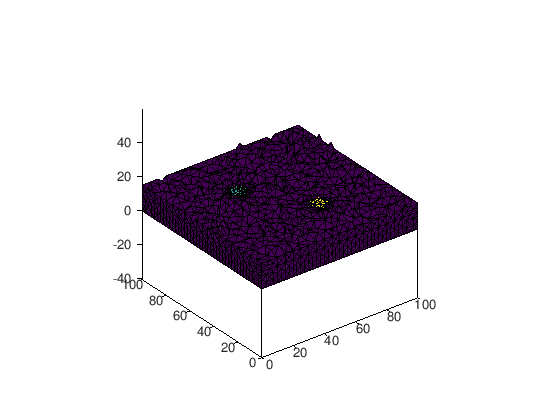

In [23]:
%%octave

clear cfg0 cfg recon
clc

domsz = [100 100 40];     % Domain size
s0    = [35, 65, 15 5;... % Central position xyz and radius of the inclusion (in mm)
         60, 30, 15 5];

% Bounding box w/ 2 inclusions
resmesh = 5;
[nobbx,elembbx] = meshgrid5(0:resmesh:domsz(1),0:resmesh:domsz(2),0:resmesh:domsz(3)); % Meshbox domain (in mm)
fcbbx   = volface(elembbx);
[nobbx,fcbbx] = removeisolatednode(nobbx,fcbbx);
[nosp1,fcsp1] = meshasphere(s0(1,1:3),s0(1,4),1); % Sphare mesh location (s0, radious, maxvol)
[nosp2,fcsp2] = meshasphere(s0(2,1:3),s0(2,4),1); % Sphare mesh location (s1, radious, maxvol)
[no,fc]       = mergemesh(nobbx,fcbbx,nosp1,fcsp1,nosp2,fcsp2); % Merge meshbox and sphere meshes (FOR DUAL INCLUSION DOMAIN)
[cfg0.node, cfg0.elem] = s2m(no,fc(:,1:3),1,25,'tetgen1.5',[11 1 1;s0(1,1:3);s0(2,1:3)]); % Generate measured/real heterogeneous domain
clear nobbx elembbx fcbbx nosp1 fcsp1 nosp2 fcsp2 no fc

% Visualize domain
figure, plotmesh(cfg0.node, cfg0.elem,char(strcat('z<',num2str(s0(1,3)))))

% General settings for RB simulations
cfg0.prop = [     0  0 1 1   ; ...
             0.006 0.8 0 1.37; ...
             0.012 0.8 0 1.37; ...
             0.012 0.8 0 1.37];
mfreq      = 0 # @param [0, 135] {type:"raw"}
cfg0.omega = mfreq*1e6*2*pi;

% Define parameter for RB widefield simulation
nBarpats   = 16; % Number of bar patterns in x/y directions
srcpattern = diag(ones(1,nBarpats));
srcpattern = permute(repmat(srcpattern,[1,1,size(srcpattern, 1)]),[2 3 1]);
srcpattern = cat(3,srcpattern,permute(srcpattern,[2 1 3]));
detpattern = srcpattern;
cfg0.srctype    = 'pattern';
cfg0.srcpos     = [20 20  0];
cfg0.srcdir     = [ 0  0  1];
cfg0.srcparam1  = [60  0 0 0];
cfg0.srcparam2  = [ 0 60 0 0];
cfg0.srcpattern = srcpattern;
cfg0.srcweight  = ones(1,nBarpats*2);
cfg0.dettype    = 'pattern';
cfg0.detpos     = [20 20 domsz(3)];
cfg0.detdir     = [ 0  0 -1];
cfg0.detparam1  = [60  0  0 0];
cfg0.detparam2  = [ 0 60  0 0];
cfg0.detpattern = srcpattern;
cfg0.detweight  = ones(1,nBarpats*2);

cfg = cfg0;
[cfg0,sd0] = rbmeshprep(cfg0);

% Run RB forward simulation
[detphi0,phi0] = rbrunforward(cfg0,'sd',sd0);

% Set fwd mesh to be homogeneous
cfg = rbsetmesh(cfg,cfg.node,cfg.elem,cfg.prop,ones(size(cfg.node,1),1));

% Prepare recon mesh
resmesh    = 5;
[no,elem]  = meshgrid5(0:resmesh:domsz(1),0:resmesh:domsz(2),0:resmesh:domsz(3)); % Meshbox domain (in mm)
fc         = volface(elem);
[no,fc]    = removeisolatednode(no,fc);
[recon.node, recon.elem] = s2m(no,fc(:,1:3),1,50,'tetgen1.5');
recon.elem = recon.elem(:,1:4);
[recon.mapid,recon.mapweight] = tsearchn(recon.node,recon.elem(:,1:4),cfg.node);
clear no elem fc


### Run bulk optical properties fitting

If utilizing FD sources, we can then perform a bulk optical properties fitting to decouple absorption and reduce scatterring coefficients. Otherwise, set them to be the true background optical properties used to generate synthetic data.

The bulk optical properties are then set as initial guess for launching the iterative reconstruction procedure.

In [24]:
%%octave

if cfg0.omega > 0 % If simulating FD data, run bulk fitting

  % Set initial guess
  recon.prop = [0     0   1 1    ; ...
                0.008 0.9 0 1.37];

  sd = rbsdmap(cfg);
  [newrecon,resid] = rbrun(cfg,recon,detphi0,sd,'mode','bulk','lambda',1e-5,'maxiter',5);

else % If running CW data, assing bulk optical properties

  % Bulk optical properties to be used
  newrecon.prop = [0       0 1 1    ; ...
                   0.006 0.8 0 1.37];

end

% Set nodal-based optical properties to the bulk fitted values
recon.prop = newrecon.prop(ones(size(recon.node,1),1)+1,:);
cfg.prop   = newrecon.prop(ones(size(cfg.node,1),1)+1,:);
cfg        = rmfield(cfg,'seg');
newrecon.prop

ans =

        0        0   1.0000   1.0000

   0.0060   0.8000        0   1.3700

### Run iterative reconstruction

In [25]:
%%octave

sd = rbsdmap(cfg);
[reconMS,residMS,cfgMS] = rbrun(cfg,recon,detphi0,sd,'mode','image','lambda',1e-6,'maxiter',5);

iter [   1]: residual=1.010603e-04, relres=1.000000e+00 lambda=1.000000e-06 (time=14.076747 s)

iter [   2]: residual=2.685685e-06, relres=2.657508e-02 lambda=1.000000e-06 (time=13.950665 s)

iter [   3]: residual=2.009516e-07, relres=1.988433e-03 lambda=1.000000e-06 (time=14.060203 s)

iter [   4]: residual=1.666475e-07, relres=1.648992e-03 lambda=1.000000e-06 (time=13.953069 s)

iter [   5]: residual=1.453360e-07, relres=1.438112e-03 lambda=1.000000e-06 (time=13.927970 s)

### Visualize reconstructed tomographic images

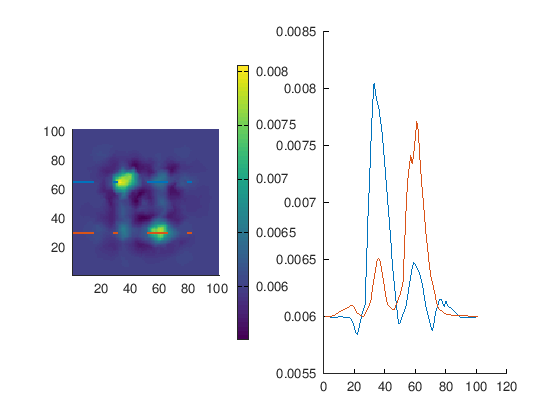

In [41]:
%%octave

% Generate a cross section slice of the domain
[xi,yi]             = meshgrid(min(cfg.node(:,1),[],1):1:max(cfg.node(:,1),[],1),min(cfg.node(:,2),[],1):1:max(cfg.node(:,2),[],1));
[cutpos,cutvalue,~] = qmeshcut(reconMS.elem,reconMS.node,(reconMS.prop(:,1)),char(strcat('z =',num2str(s0(1,3)))));
clear vphi
vphi(:,:,1)         = griddata(cutpos(:,1),cutpos(:,2),cutvalue,xi,yi);

% Visualize results
figure,
subplot(1,2,1);
axis equal
hold on;
imagesc(vphi);
colorbar;
axis tight;
for mm = 1:size(s0,1)
    hold on,plot(1:size(vphi,2),s0(mm,2).*ones(1,size(vphi,2)),'LineWidth',4,'LineStyle','-.')
end
subplot(1,2,2)
for mm = 1:size(s0,1)
    hold on,plot(vphi(s0(mm,2),:))
end